In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
from pathos.multiprocessing import ProcessPool
import errno
import dill
import sys
sys.path.append('../')

import neat
from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser

import itertools as it
import time
import imageio

import sgr_main as sgr
from matplotlib import pyplot as plt


from substrates import morph_substrate, control_substrate
from generate_robot import generate_robot
from evogym_sim import simulate_env
from body_speciation import CustomGenome


In [2]:
def get_robot(genome, params, neat_config):
    cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)

    design_substrate = morph_substrate(params)
    design_net = create_phenotype_network(cppn, design_substrate)

    robot = generate_robot(design_net, params)
    if not sgr.eval_genome_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    if params["env"] == "dynamic":
        env = DynamicObstacleTraverser(body=robot, connections=connections)
    else:
        env = evogym.envs.gym.make(params["env"], body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [3]:
ENV = "dynamic" # env_names = ["CaveCrawler-v0", "UpStepper-v0", "ObstacleTraverser-v1"]
STEPS = 600
ROBOT_SIZE = 5
POP = 128

# directory = "results/" + ENV
directory = "results/Walker-v0"

file = "run_1_pop.pkl"
params = {"robot_size": ROBOT_SIZE, "env": ENV, "steps": STEPS, "pop_size": POP, "robot_substrate": "AA"}

CustomGenome.params = params
CustomGenome.robot_func = lambda self, net, params: generate_robot(net, params)
CustomGenome.substrate = morph_substrate(params)


neat_config = neat.config.Config(
    CustomGenome,
    neat.reproduction.DefaultReproduction, 
    neat.species.DefaultSpeciesSet, 
    neat.stagnation.DefaultStagnation, 
    "../configs/hyperNEAT.cfg"
)

input_size = 3*2 + 1 # two coordinates plus the bias
neat_config.genome_config.num_inputs = input_size
neat_config.genome_config.input_keys = [-1*i for i in range(1, input_size+1)]
neat_config.genome_config.num_outputs = 1
neat_config.genome_config.output_keys = [0]

with open(f"../{directory}/{file}", "rb") as file:
    pop = dill.load(file)
champion = pop.best_genome
print(champion.fitness)

6.351765789899895


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  54 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
0.06389368332495121
0.07886350813931065
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15517 0.07886350813931065


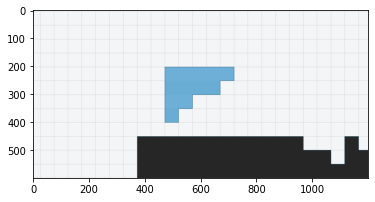

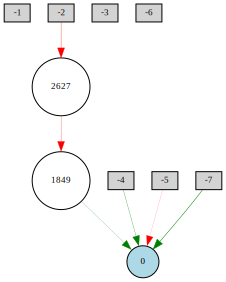

-0.7314430241719878
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15603 -0.7314430241719878


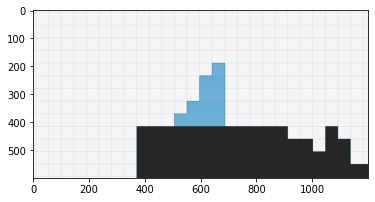

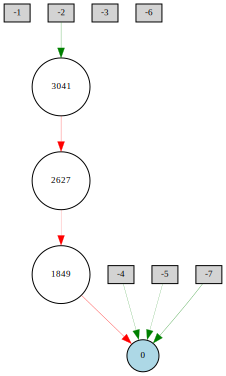

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  43 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
-10000
0.2962090054218597
-0.011740377829058457
-10000
-10000
-10000
-10000
-10000
-10000
-10000
-10000
-10000
-10000
-10000
-10000
-10000
-10000
-10000
-10000
-10000
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  42 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
0.3675942162124195
-0.14778377180790242
[[4. 4. 4. 4. 4.]
 [1. 4. 4. 4. 4.]
 [1. 1. 0. 4. 4.]
 [1. 1. 1. 1. 4.]
 [1. 1. 1. 1. 1.]]
15616 -0.14778377180790242


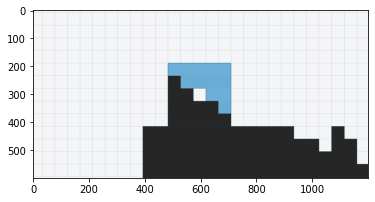

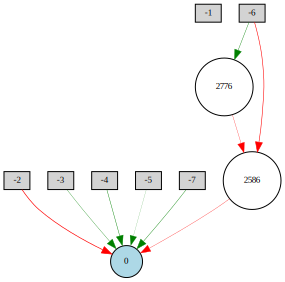

-0.24164867817948346
[[4. 4. 4. 1. 1.]
 [4. 4. 4. 1. 1.]
 [4. 4. 0. 1. 1.]
 [4. 4. 1. 1. 1.]
 [4. 4. 1. 1. 1.]]
15618 -0.24164867817948346


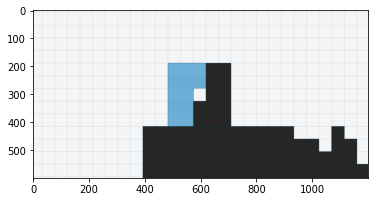

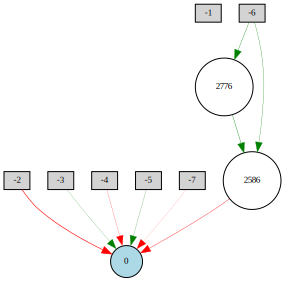

0.022103722980757357
[[0. 0. 4. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]]
15619 0.022103722980757357


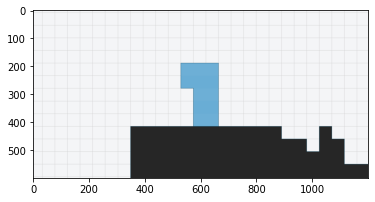

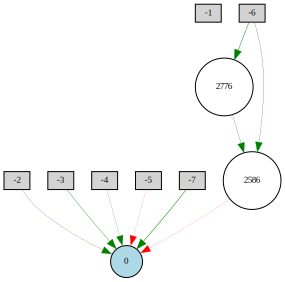

0.39385597188973376
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  52 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3.6391623439218224
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15649 3.6391623439218224


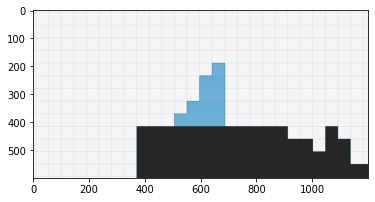

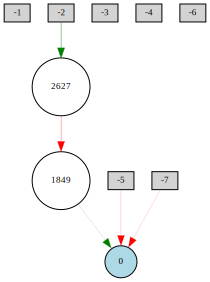

1.9248255688432963
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15562 1.9248255688432963


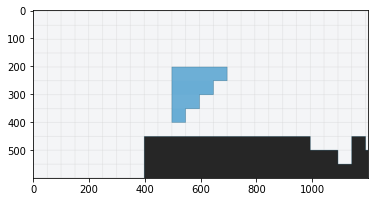

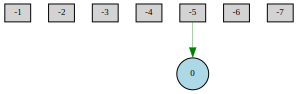

1.9408877149609491
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15608 1.9408877149609491


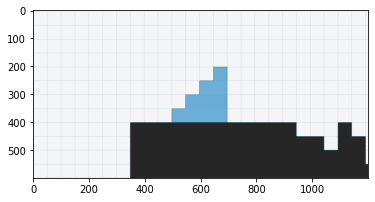

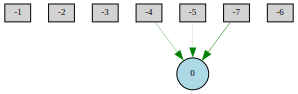

0.025566861440785182
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15614 0.025566861440785182


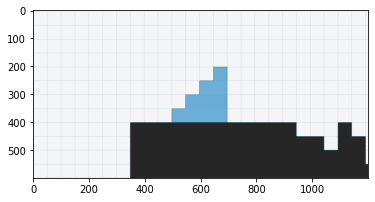

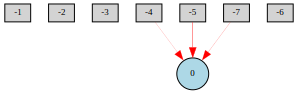

1.9394199072676046
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15620 1.9394199072676046


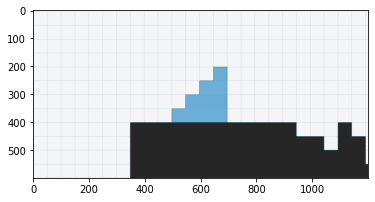

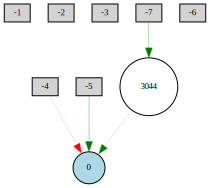

1.9386009234711739
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15622 1.9386009234711739


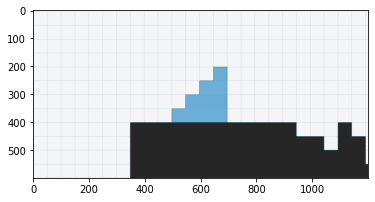

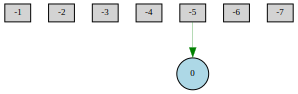

1.9392726646267913
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15623 1.9392726646267913


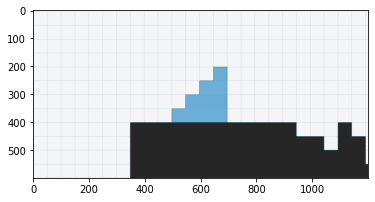

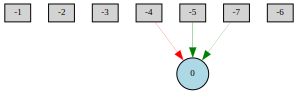

1.1821430736487757
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15624 1.1821430736487757


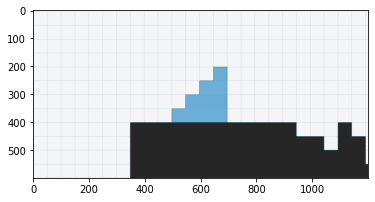

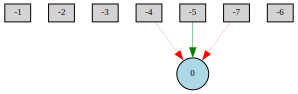

1.9371861904902485
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15625 1.9371861904902485


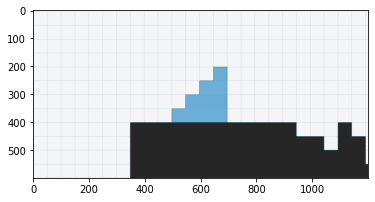

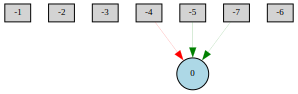

-0.07777753443050395
1.951964251052126
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15255 1.951964251052126


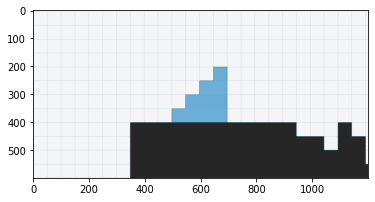

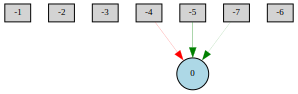

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  38 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
1.517663866808281
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 3.]
 [4. 4. 0. 3. 3.]
 [4. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3.]]
13059 1.517663866808281


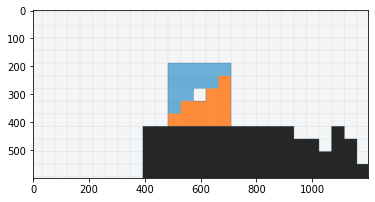

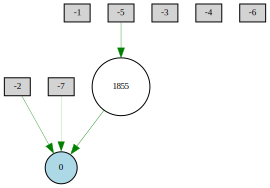

0.008301065896810289
-0.6187164248824595
-3.1817879871236805
0.07377297221145046
1.013592657518225
[[2. 2. 2. 2. 2.]
 [4. 2. 2. 2. 2.]
 [4. 4. 0. 2. 2.]
 [4. 4. 4. 4. 2.]
 [4. 4. 4. 4. 4.]]
15684 1.013592657518225


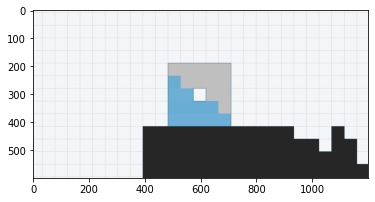

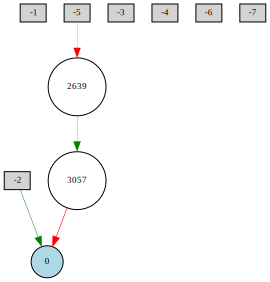

1.975491806872287
[[3. 3. 3. 3. 3.]
 [0. 3. 3. 3. 3.]
 [0. 0. 0. 3. 3.]
 [0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 0.]]
13738 1.975491806872287


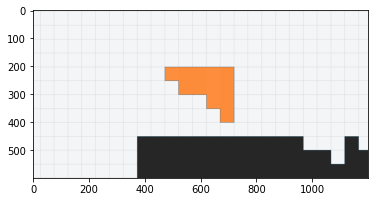

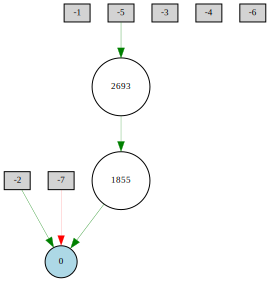

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  50 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
1.1434070152786608
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15660 1.1434070152786608


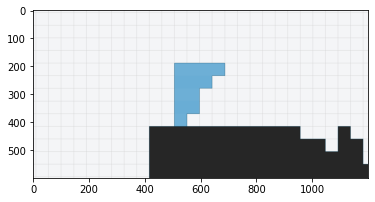

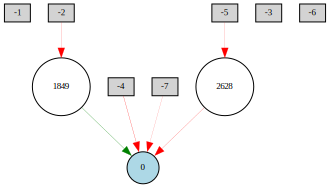

2.8265077650632153
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15379 2.8265077650632153


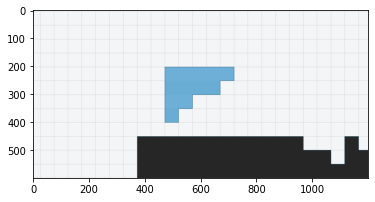

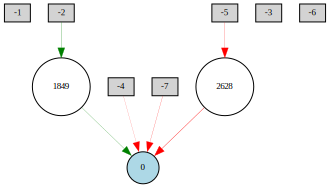

3.1509825466019197
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15568 3.1509825466019197


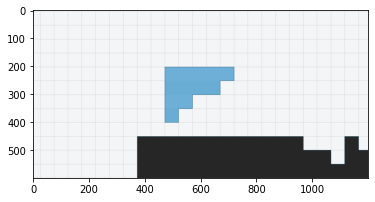

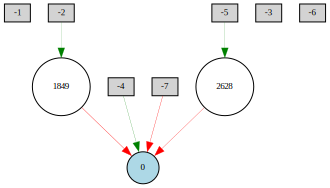

1.436909221824601
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15631 1.436909221824601


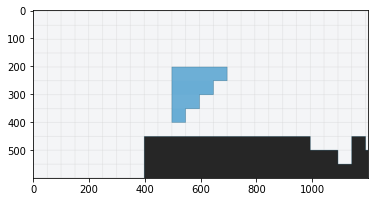

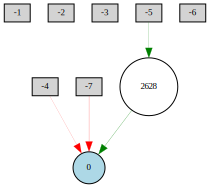

1.558883318999924
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15662 1.558883318999924


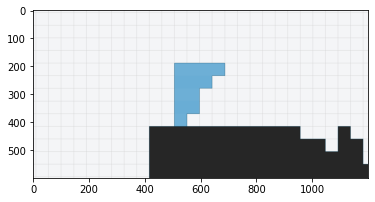

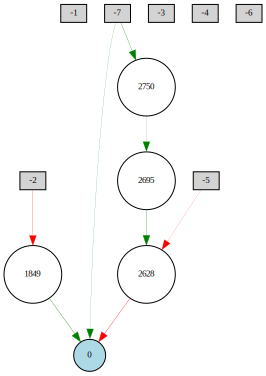

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  39 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3.172280408907422
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
13917 3.172280408907422


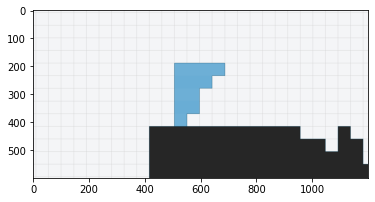

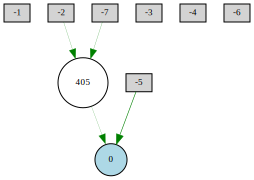

1.4876071621979106
-10000
-10000
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  46 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
2.9242074505883138
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15641 2.9242074505883138


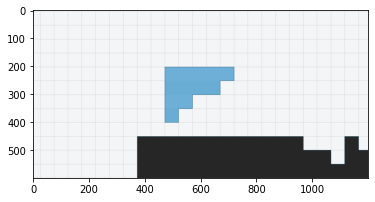

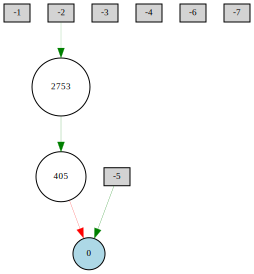

3.4373103543793366
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15385 3.4373103543793366


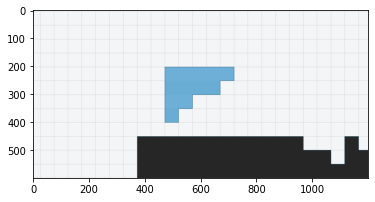

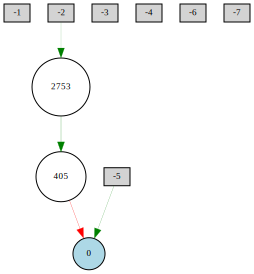

3.21026538814195
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15548 3.21026538814195


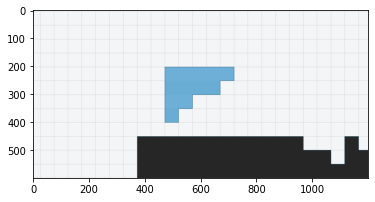

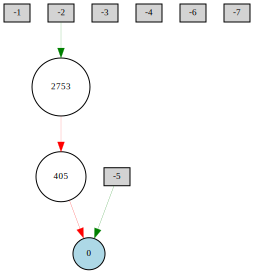

-0.10158395127388703
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15642 -0.10158395127388703


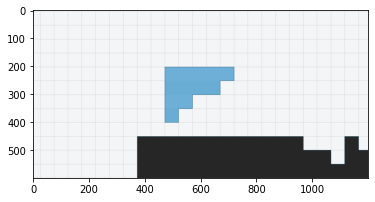

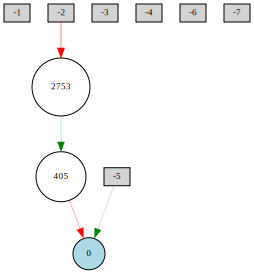

1.8698745476968188
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15668 1.8698745476968188


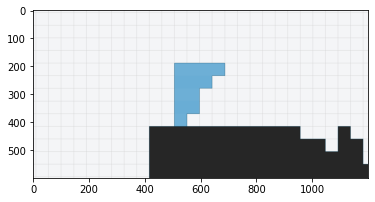

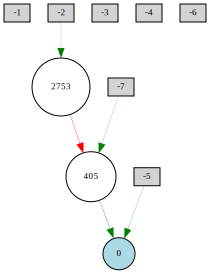

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  49 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3.748539903055247
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15047 3.748539903055247


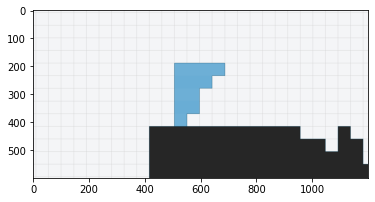

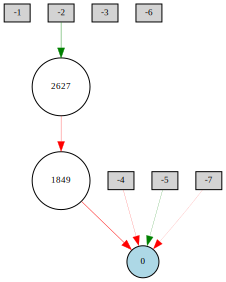

3.706770611480616
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15526 3.706770611480616


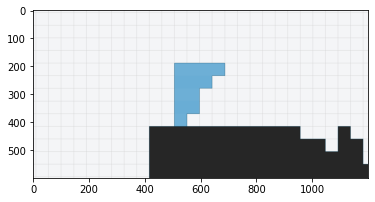

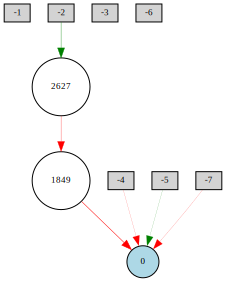

0.013123978833168293
0.6058479797327367
2.6766632538962396
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15645 2.6766632538962396


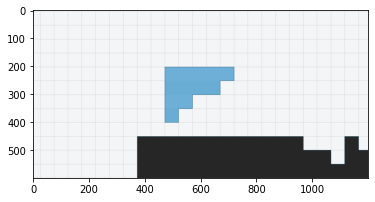

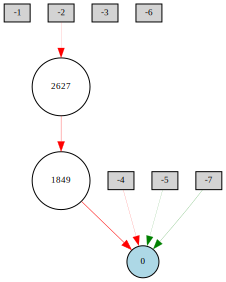

-3.724311212523375
4.217227126793449
3.9716591525136957
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15651 3.9716591525136957


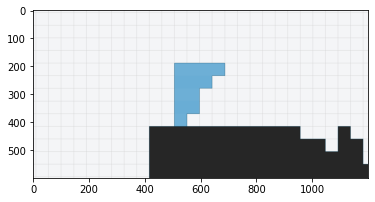

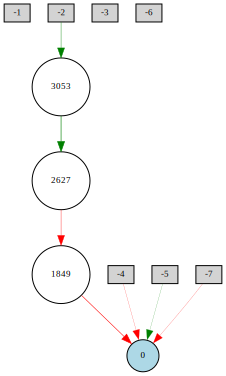

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  51 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
4.082403235583086
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15141 4.082403235583086


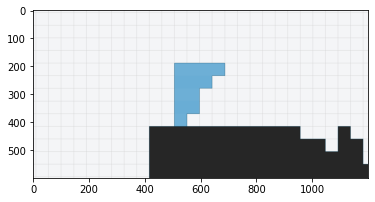

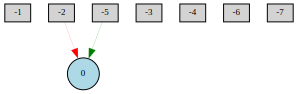

-0.23478192896386552
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15557 -0.23478192896386552


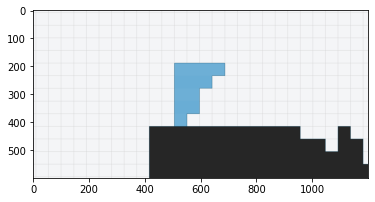

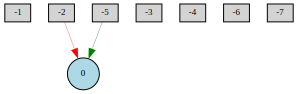

1.9951658576130438
2.0006721315705245
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15654 2.0006721315705245


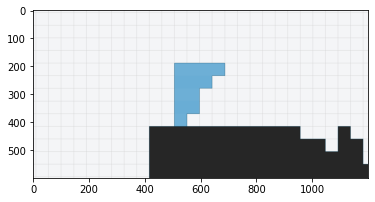

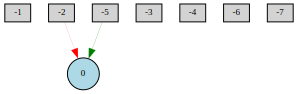

-0.2886565388512393
3.8655143734126547
[[4. 4. 4. 0. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]]
15685 3.8655143734126547


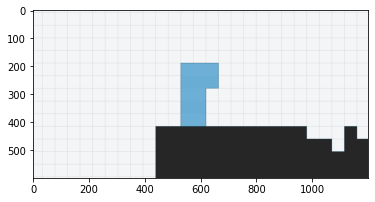

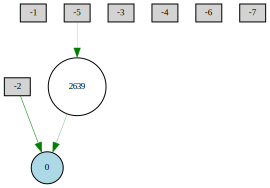

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  41 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
4.218931762947033
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
14843 4.218931762947033


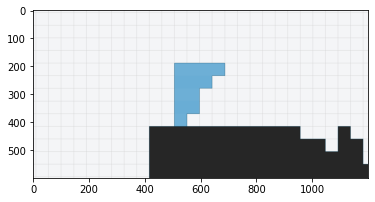

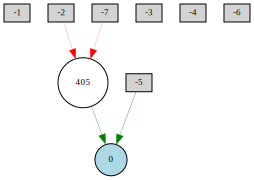

3.2610091983287997
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15655 3.2610091983287997


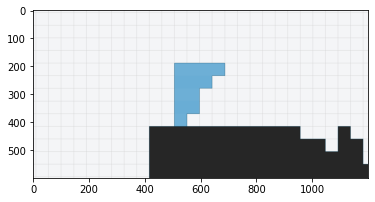

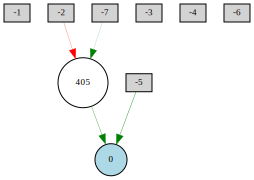

-10000
-2.9885864910837148
4.225643889364735
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15659 4.225643889364735


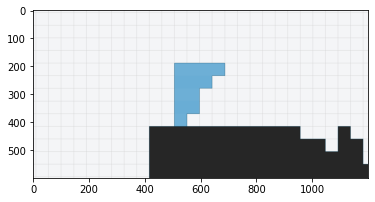

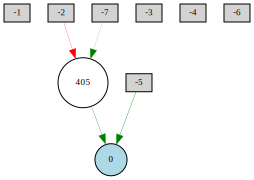

4.2240780620365355
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15187 4.2240780620365355


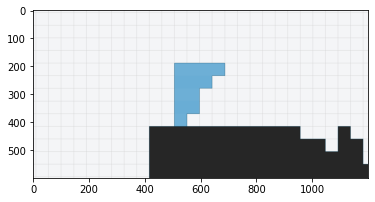

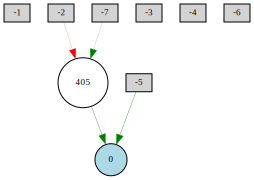

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  45 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
4.5226065300387805
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]]
14138 4.5226065300387805


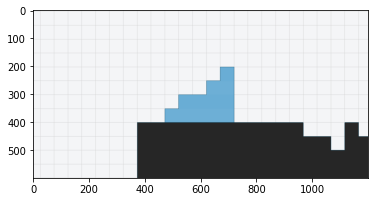

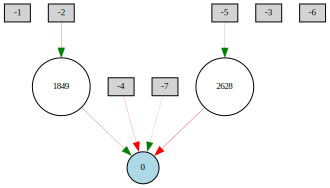

5.2973821066306925
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15632 5.2973821066306925


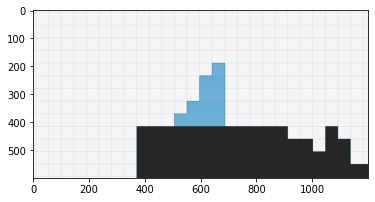

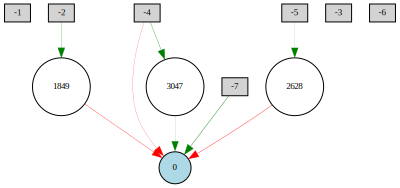

5.557596995845574
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15634 5.557596995845574


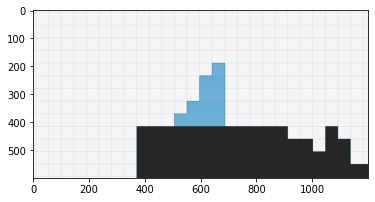

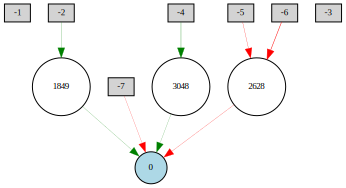

-0.24959905674491997
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15661 -0.24959905674491997


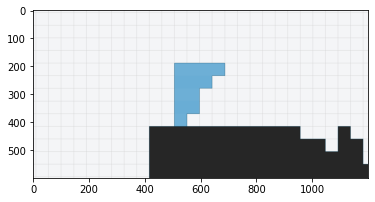

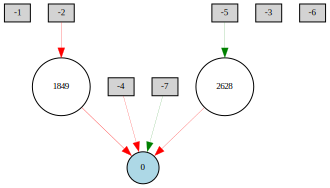

-10000
4.992478435280215
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15343 4.992478435280215


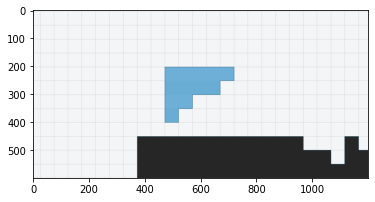

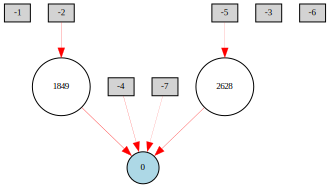

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  48 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
4.400749754630261
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]]
15665 4.400749754630261


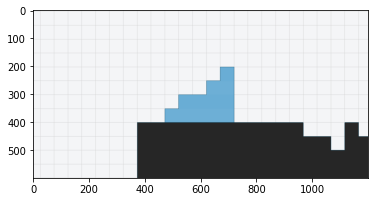

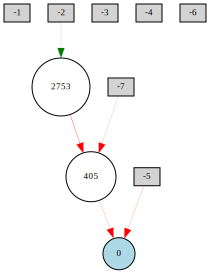

4.932301690093529
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15386 4.932301690093529


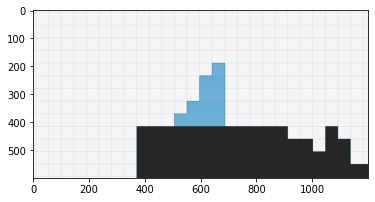

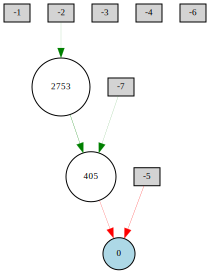

5.012228516653814
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15564 5.012228516653814


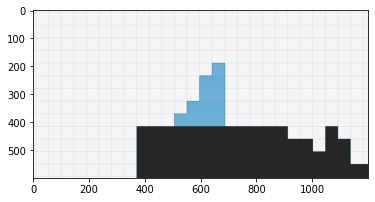

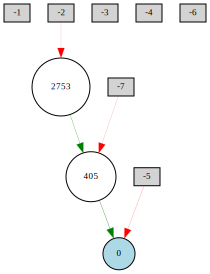

5.799996013120895
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15664 5.799996013120895


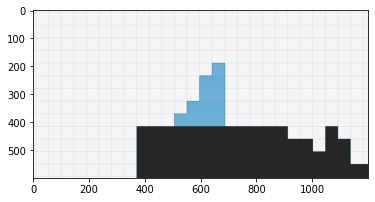

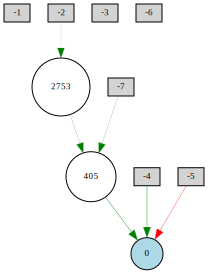

1.9551740690870743
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15666 1.9551740690870743


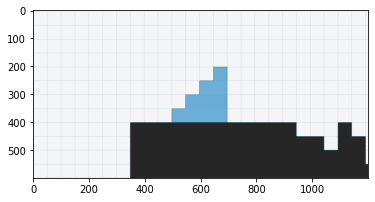

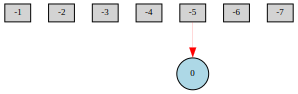

5.036273007044527
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15667 5.036273007044527


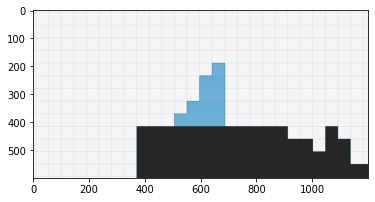

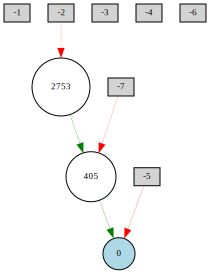

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  53 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
5.400395462636771
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
14637 5.400395462636771


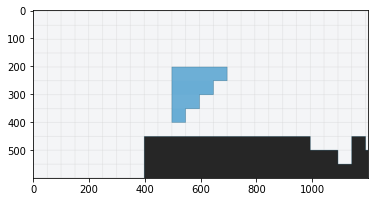

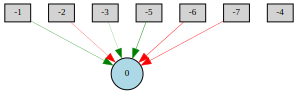

3.3676500517821446
-10000
-10000
1.7756212080329328
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15672 1.7756212080329328


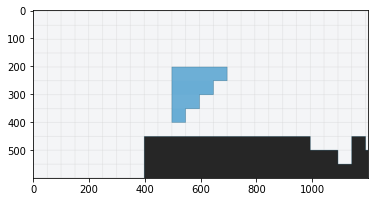

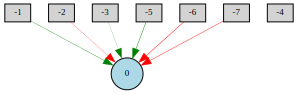

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  27 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
5.606769957886351
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
14860 5.606769957886351


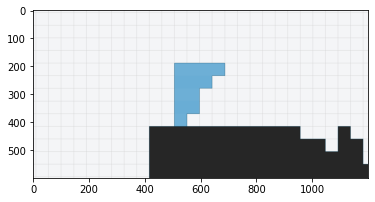

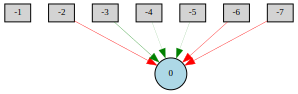

2.800503807316124
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15489 2.800503807316124


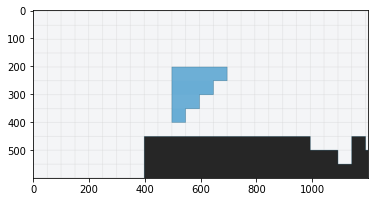

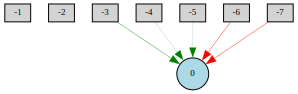

1.7055126908840281
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15643 1.7055126908840281


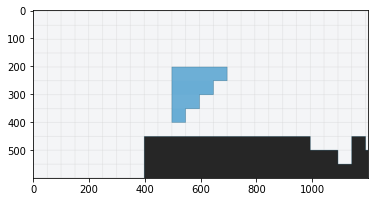

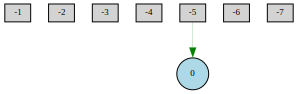

1.519332615576776
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15673 1.519332615576776


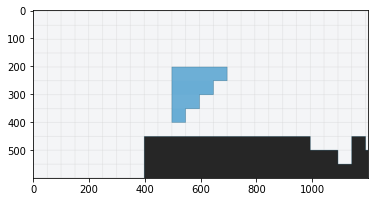

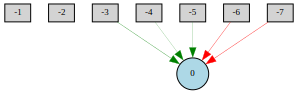

0.1966468000218432
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15675 0.1966468000218432


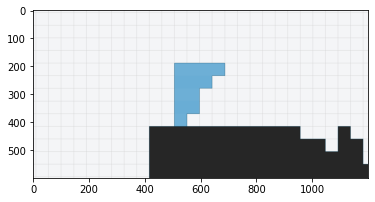

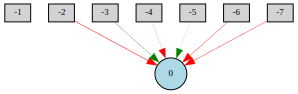

2.3336908670404237
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
15676 2.3336908670404237


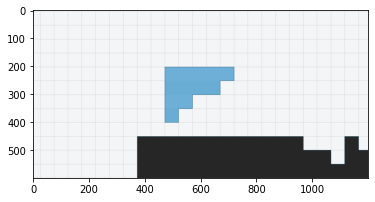

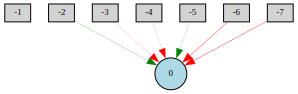

2.315636312089074
[[4. 4. 4. 4. 0.]
 [4. 4. 4. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]]
15677 2.315636312089074


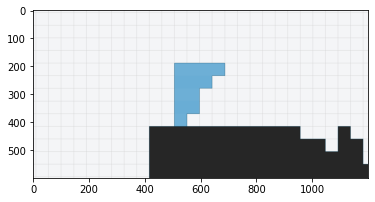

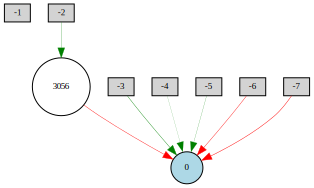

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  47 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
5.746097319651167
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
14525 5.746097319651167


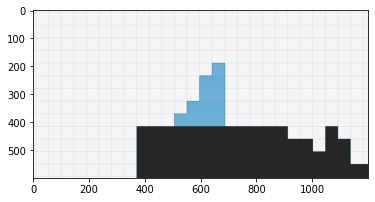

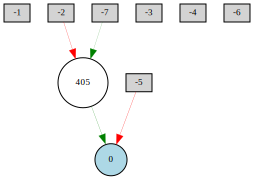

1.91166801595221
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15639 1.91166801595221


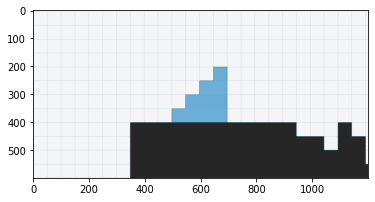

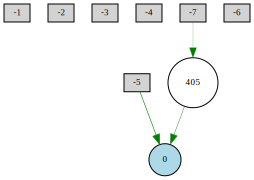

4.8690622789202065
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15640 4.8690622789202065


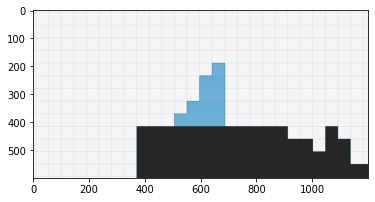

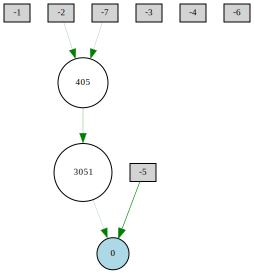

3.6513917352537675
5.2881688841256045
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15658 5.2881688841256045


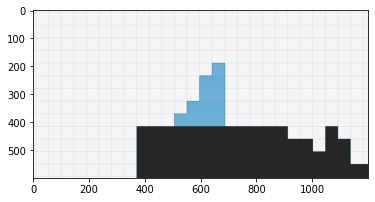

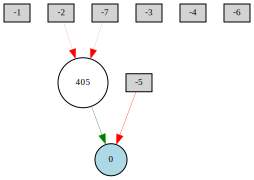

-0.15578431737431137
4.153259374930276
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]]
15679 4.153259374930276


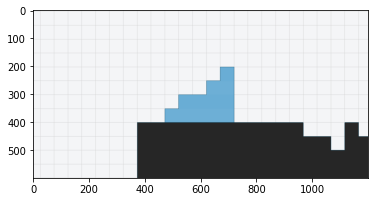

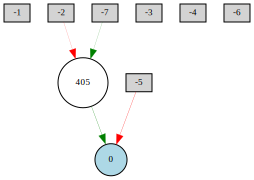

1.2921660286847751
5.632769559848986
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  44 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
5.968267897952851
-0.019380195274894263
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15670 -0.019380195274894263


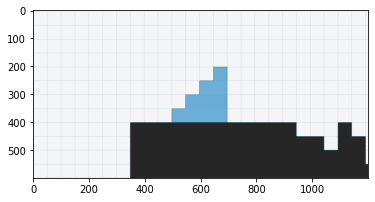

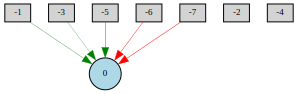

4.04891008076934
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15682 4.04891008076934


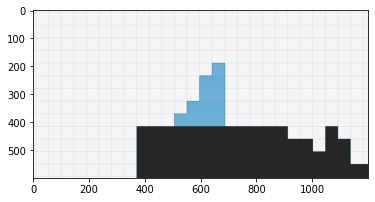

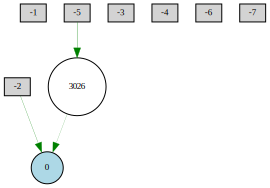

3.904285753671117
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15686 3.904285753671117


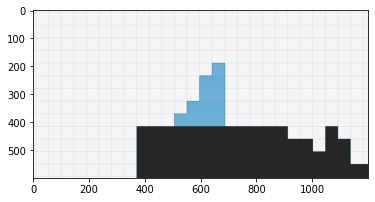

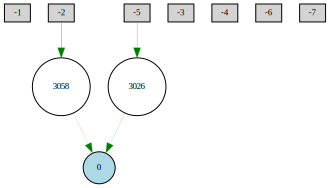

-0.8256742114583693
5.1835448941117495
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
6.351765789899895
6.246546159601407
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
5818 6.246546159601407


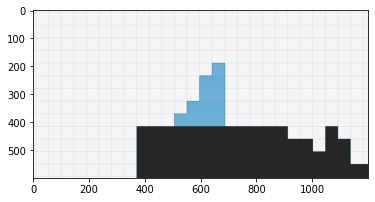

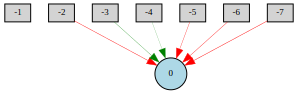

0.49399061654489845
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]]
15615 0.49399061654489845


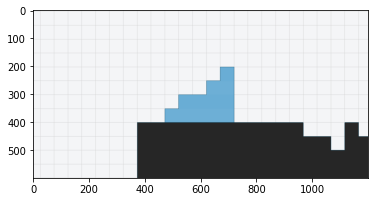

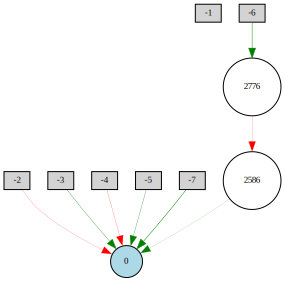

3.890844938373197
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15674 3.890844938373197


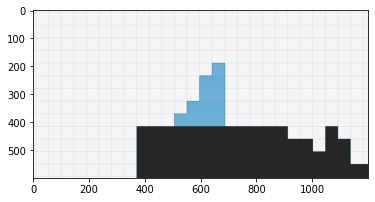

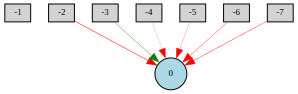

-10000
4.415068435126755
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15690 4.415068435126755


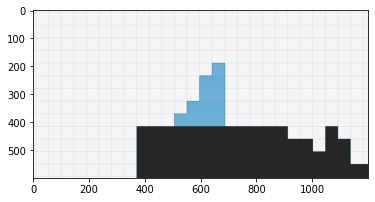

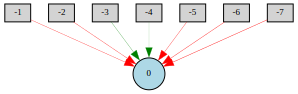

-10000
1.9180493752612362
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15692 1.9180493752612362


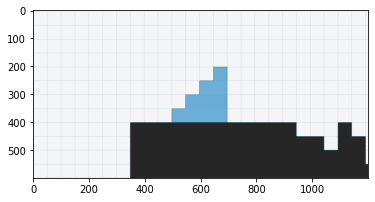

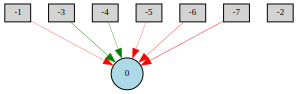

3.2576337908711337
[[0. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [4. 4. 0. 0. 0.]
 [4. 4. 4. 4. 0.]
 [4. 4. 4. 4. 4.]]
15693 3.2576337908711337


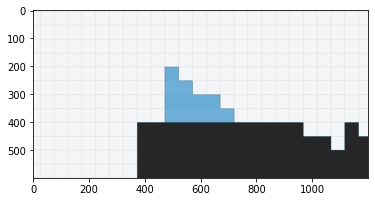

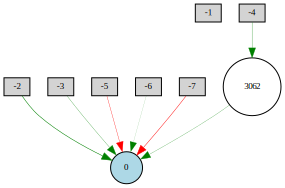

4.713436428048191
[[0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 4. 4. 4. 4.]]
15694 4.713436428048191


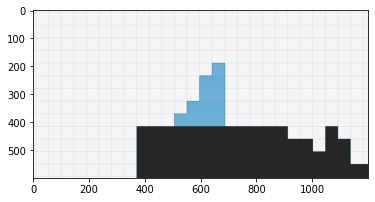

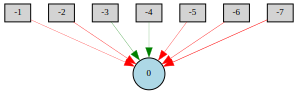

In [4]:
for k, v in pop.species.species.items():
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie ", k, "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    
    for g in v.members.values():
        print(g.fitness)
        print
        if g.fitness != None and g.fitness > -1:
            r, img = get_robot(g, params, neat_config)
            if img is not None:
                print(r)
                print(g.key, g.fitness)
                plt.imshow(img)
                plt.show()
                net = neat.nn.FeedForwardNetwork.create(g, neat_config)
                display(draw_net(net))

In [5]:
g = pop.best_genome
# g = pop.population[14774]
params["save_to"] = "walker"
sgr.single_genome_fit(g, params, neat_config, True, False)
# sgr.single_genome_fit(g, params, neat_config, False, True)

(-0.012472681301894939, False)

In [6]:
base = pop.population[12892]
r2 = pop.population[14520]

_, img = get_robot(base, params, neat_config)
plt.imshow(img)
plt.show()
net = neat.nn.FeedForwardNetwork.create(base, neat_config)
display(draw_net(net))

_, img = get_robot(r2, params, neat_config)
plt.imshow(img)
plt.show()
net = neat.nn.FeedForwardNetwork.create(r2, neat_config)
display(draw_net(net))


neat_config.compatibility_disjoint_coefficient = 1
neat_config.compatibility_weight_coefficient = .6

base.distance = f
print(base.distance(base, r2, neat_config))


print()

base.distance =  neat.DefaultGenome.distance
print(base.distance(base, r2, neat_config))


KeyError: 12892